<a href="https://colab.research.google.com/github/isdeniz/paper-24/blob/main/nlbse22_roberta_case3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter
import re
import unicodedata as ud
from nltk.corpus import wordnet as wn
from nltk.corpus import words as w
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
import os

#Retrieving datasets

In [2]:
test = pd.read_csv('/content/drive/My Drive/nlbse22/github-labels-top3-803k-test.csv')
train = pd.read_csv('/content/drive/My Drive/nlbse22/github-labels-top3-803k-train.csv')
print('test:', test.shape, 'train:', train.shape)

test: (80518, 8) train: (722899, 8)


In [3]:
train.head()

,Unnamed: 0,issue_url,issue_label,issue_created_at,issue_author_association,repository_url,issue_title,issue_body
0,0,https://api.github.com/repos/eamodio/vscode-gi...,bug,2021-01-02T18:07:30Z,NONE,https://api.github.com/repos/eamodio/vscode-gi...,Welcome screen on every editor window is very ...,I just discovered Gitlens and find the functio...
1,1,https://api.github.com/repos/binwiederhier/pco...,bug,2020-12-31T18:19:31Z,OWNER,https://api.github.com/repos/binwiederhier/pcopy,"""pcopy invite"" and ""pcopy paste abc:"" does not...",NaN
2,2,https://api.github.com/repos/binwiederhier/pco...,bug,2021-01-03T04:33:36Z,OWNER,https://api.github.com/repos/binwiederhier/pcopy,"UI: Modal overlay is half transparent, shouldn...",NaN
3,3,https://api.github.com/repos/Sothatsit/RoyalUr...,enhancement,2020-12-25T00:46:00Z,OWNER,https://api.github.com/repos/Sothatsit/RoyalUr...,Make the loading screen scale with browser win...,Currently the loading wheel is a fixed size in...
4,4,https://api.github.com/repos/Malivil/TTT-Custo...,bug,2021-01-02T21:36:57Z,OWNER,https://api.github.com/repos/Malivil/TTT-Custo...,Spectator - Investigate a way to strip weapons...,To bring magneto stick floating


In [4]:
test.head()

,Unnamed: 0,issue_url,issue_label,issue_created_at,issue_author_association,repository_url,issue_title,issue_body
0,6,https://api.github.com/repos/tlnagy/TIFF.jl/is...,enhancement,2020-04-07T09:08:50Z,NONE,https://api.github.com/repos/tlnagy/TIFF.jl,"ERROR: KeyError: key (TIFF.SAMPLEFORMAT_INT, 0...",One more error might need to be caught.\r\n`4D...
1,19,https://api.github.com/repos/tisboyo/Twitch_Bo...,enhancement,2020-11-27T07:17:21Z,OWNER,https://api.github.com/repos/tisboyo/Twitch_Bot,Add database backup to dropbox,NaN
2,25,https://api.github.com/repos/DrWhoCares/imgdan...,enhancement,2021-01-02T19:35:34Z,OWNER,https://api.github.com/repos/DrWhoCares/imgdanke,Add a button/method to open the Source or Outp...,Could also add a method to open up path to eac...
3,30,https://api.github.com/repos/DrWhoCares/imgdan...,bug,2021-01-02T20:55:34Z,OWNER,https://api.github.com/repos/DrWhoCares/imgdanke,Processes are being started twice,At some point I refactored a few things and en...
4,54,https://api.github.com/repos/Bean-1/AOT/issues/3,bug,2020-12-29T15:34:35Z,OWNER,https://api.github.com/repos/Bean-1/AOT,Cannot add hp to wall,NaN


#Preprocessing

Remove the issue reports from the training set which appear both in the training and tests

In [5]:
mask = train['issue_url'].isin(test['issue_url'])
count = mask.sum()
print(count)

7086


In [6]:
mask = test['issue_url'].isin(train['issue_url'])
count = mask.sum()
print(count)

5550


In [7]:
mask = train['issue_url'].isin(test['issue_url'])
count = mask.sum()
print(f"Number of rows to remove: {count}")

train_cleaned = train.copy(deep = True)

train_cleaned = train_cleaned[~mask]

print('Number of cleaned issues: ' , train.shape[0] - train_cleaned.shape[0], 'Final size of the train set: ', train_cleaned.shape[0])

Number of rows to remove: 7086
Number of cleaned issues:  7086 Final size of the train set:  715813


In [8]:
mask = train_cleaned['issue_url'].isin(test['issue_url'])
count = mask.sum()
print(count)

0


In [9]:
mask = test['issue_url'].isin(train_cleaned['issue_url'])
count = mask.sum()
print(count)

0


In [10]:
train_cleaned['issue_label'].value_counts()

,count
issue_label,
bug,357293
enhancement,297000
question,61520


In [11]:
test['issue_label'].value_counts()

,count
issue_label,
bug,40288
enhancement,33203
question,7027


In [12]:
train_cleaned['original_issue_title'] = train_cleaned['issue_title']
train_cleaned['original_issue_body'] = train_cleaned['issue_body']

train_cleaned.rename(columns={'issue_title': 'preprocessed_title'}, inplace=True)
train_cleaned.rename(columns={'issue_body': 'preprocessed_body'}, inplace=True)

test['original_issue_title'] = test['issue_title']
test['original_issue_body'] = test['issue_body']

test.rename(columns={'issue_title': 'preprocessed_title'}, inplace=True)
test.rename(columns={'issue_body': 'preprocessed_body'}, inplace=True)

In [13]:
label = 'issue_label'
time = 'issue_created_at'
repo = 'repository_url'
title  = 'preprocessed_title'
body = 'preprocessed_body'
author = 'issue_author_association'
url = 'issue_url'
label_col = 'labels'
text_col = 'text'
max_title = 30
max_body = 170
# punctuations = '!"$%&\()*,/:;<=>[\\]^`{|}~+#@-`' below line is added since this line (original) gives SyntaxWarning: invalid escape sequence '\('
punctuations = r'!"$%&\()*,/:;<=>[\\]^`{|}~+#@-`'
ascii_regex = re.compile(r'[^\x00-\x7f]')
issue_regex = re.compile(r'#[0-9]+')
function_regex = re.compile(r'[a-zA-Z][a-zA-Z0-9_.]*\([a-zA-Z0-9_, ]*\)')

deduplicate the TRAINING dataset based on issue URls

In [14]:
dedup_train = train_cleaned.sort_values(url).drop_duplicates(subset=[url]).copy()
print('Number of dropped issue duplications: ' , train_cleaned.shape[0] - dedup_train.shape[0])

dedup_train[title] = dedup_train[title].astype(str)
dedup_train[body] = dedup_train[body].astype(str)
dedup_train[author] = dedup_train[author].astype(str)
dedup_train[time] = dedup_train[time].astype(str)
dedup_train[repo] = dedup_train[repo].astype(str)

test[title] = test[title].astype(str)
test[body] = test[body].astype(str)
test[author] = test[author].astype(str)
test[time] = test[time].astype(str)
test[repo] = test[repo].astype(str)

Number of dropped issue duplications:  24560


In [15]:
mask = dedup_train['issue_url'].isin(test['issue_url'])
count = mask.sum()
print(count)

0


In [16]:
mask = test['issue_url'].isin(dedup_train['issue_url'])
count = mask.sum()
print(count)

0


text normalization on text columns of issues

In [17]:
print('Replacing functions...')
dedup_train[body] = dedup_train[body].apply(lambda x:function_regex.sub(" function ",x))
test[body] = test[body].apply(lambda x:function_regex.sub(" function ",x))

print('Replacing issue numbers...')
dedup_train[title] = dedup_train[title].apply(lambda x:issue_regex.sub(" issue ",x))
dedup_train[body] = dedup_train[body].apply(lambda x:issue_regex.sub(" issue ",x))
test[title] = test[title].apply(lambda x:issue_regex.sub(" issue ",x))
test[body] = test[body].apply(lambda x:issue_regex.sub(" issue ",x))

print('Converting to lower case...')
dedup_train[title] = dedup_train[title].str.lower()
dedup_train[body] = dedup_train[body].str.lower()
test[title] = test[title].str.lower()
test[body] = test[body].str.lower()

Replacing functions...
Replacing issue numbers...
Converting to lower case...


remove extra information from text

In [18]:
print('Removing punctuations...')
replace_string = ' '*len(punctuations)
dedup_train[title] = dedup_train[title].str.translate(str.maketrans(punctuations, replace_string))
dedup_train[body] = dedup_train[body].str.translate(str.maketrans(punctuations, replace_string))
test[title] = test[title].str.translate(str.maketrans(punctuations, replace_string))
test[body] = test[body].str.translate(str.maketrans(punctuations, replace_string))

print('Removing non-ascii charachters...')
dedup_train[title] = dedup_train[title].apply(lambda x:re.sub(ascii_regex, '', x))
dedup_train[title] = dedup_train[title].apply(lambda x:ud.normalize('NFD', x))
dedup_train[body] = dedup_train[body].apply(lambda x:re.sub(ascii_regex, '', x))
dedup_train[body] = dedup_train[body].apply(lambda x:ud.normalize('NFD', x))

test[title] = test[title].apply(lambda x:re.sub(ascii_regex, '', x))
test[title] = test[title].apply(lambda x:ud.normalize('NFD', x))
test[body] = test[body].apply(lambda x:re.sub(ascii_regex, '', x))
test[body] = test[body].apply(lambda x:ud.normalize('NFD', x))

print('Replacing fixed part of repo URl column...')
dedup_train[repo] = dedup_train[repo].apply(lambda x: x.replace('https://api.github.com/repos/', ''))
test[repo] = test[repo].apply(lambda x: x.replace('https://api.github.com/repos/', ''))

print('Replacing white spaces...')
dedup_train[title] = dedup_train[title].apply(lambda x:" ".join(x.split()))
dedup_train[body] = dedup_train[body].apply(lambda x:" ".join(x.split()))
test[title] = test[title].apply(lambda x:" ".join(x.split()))
test[body] = test[body].apply(lambda x:" ".join(x.split()))

Removing punctuations...
Removing non-ascii charachters...
Replacing fixed part of repo URl column...
Replacing white spaces...


check the number of tokens in the issue title and issue body

Train

In [19]:
dedup_train['title_token_count'] = dedup_train[title].apply(lambda x: len(x.split()))
print(f"Average number of tokens in issue title: {dedup_train['title_token_count'].mean()}, Median of tokens in issue title: {dedup_train['title_token_count'].median()}")

Average number of tokens in issue title: 6.763788366922096, Median of tokens in issue title: 6.0


In [20]:
dedup_train['body_token_count'] = dedup_train[body].apply(lambda x: len(x.split()))
print(f"Average number of tokens in issue body: {dedup_train['body_token_count'].mean()}, Median of tokens in issue body: {dedup_train['body_token_count'].median()}")

Average number of tokens in issue body: 117.1536326062961, Median of tokens in issue body: 49.0


Test

In [21]:
test['title_token_count'] = test[title].apply(lambda x: len(x.split()))
print(f"Average number of tokens in issue title: {test['title_token_count'].mean()}, Median of tokens in issue title: {test['title_token_count'].median()}")

Average number of tokens in issue title: 6.7562284209741925, Median of tokens in issue title: 6.0


In [22]:
test['body_token_count'] = test[body].apply(lambda x: len(x.split()))
print(f"Average number of tokens in issue body: {test['body_token_count'].mean()}, Median of tokens in issue body: {test['body_token_count'].median()}")

Average number of tokens in issue body: 117.74881392980451, Median of tokens in issue body: 49.0


truncate columns

In [23]:
dedup_train[title] = dedup_train[title].apply(lambda x: ' '.join(x.split(maxsplit=max_title)[:max_title]))
dedup_train[body] = dedup_train[body].apply(lambda x: ' '.join(x.split(maxsplit=max_body)[:max_body]))
test[title] = test[title].apply(lambda x: ' '.join(x.split(maxsplit=max_title)[:max_title]))
test[body] = test[body].apply(lambda x: ' '.join(x.split(maxsplit=max_body)[:max_body]))

prepare labels column

In [24]:
dedup_train[label] = pd.Categorical(dedup_train[label])
test[label] = pd.Categorical(test[label])
dedup_train[label_col] = dedup_train[label].cat.codes
test[label_col] = test[label].cat.codes

concat issue columns in one "text" column to feed the BERT model

In [25]:
dedup_train[text_col] = 'time ' + dedup_train[time] + ' author ' + dedup_train[author] + ' title ' + dedup_train[title] + ' body ' + dedup_train[body]
test[text_col] = 'time ' + test[time] + ' author ' + test[author] + ' title ' + test[title] + ' body ' + test[body]

In [26]:
dedup_train.head(1)

,Unnamed: 0,issue_url,issue_label,issue_created_at,issue_author_association,repository_url,preprocessed_title,preprocessed_body,original_issue_title,original_issue_body,title_token_count,body_token_count,labels,text
258501,287489,https://api.github.com/repos/0-Yama/Projet-Fin...,enhancement,2021-05-26T20:57:00Z,OWNER,0-Yama/Projet-Final-Python,the beginning,we need to add the first file of our project,The beginning,We need to add the first file of our project,2,10,1,time 2021-05-26T20:57:00Z author OWNER title t...


In [27]:
test.head(1)

,Unnamed: 0,issue_url,issue_label,issue_created_at,issue_author_association,repository_url,preprocessed_title,preprocessed_body,original_issue_title,original_issue_body,title_token_count,body_token_count,labels,text
0,6,https://api.github.com/repos/tlnagy/TIFF.jl/is...,enhancement,2020-04-07T09:08:50Z,NONE,tlnagy/TIFF.jl,error keyerror key tiff.sampleformat_int 0x000...,one more error might need to be caught. 4d ser...,"ERROR: KeyError: key (TIFF.SAMPLEFORMAT_INT, 0...",One more error might need to be caught.\r\n`4D...,7,86,1,time 2020-04-07T09:08:50Z author NONE title er...


In [28]:
dedup_train['issue_label'].value_counts()

,count
issue_label,
bug,344994
enhancement,288015
question,58244


In [29]:
test['issue_label'].value_counts()

,count
issue_label,
bug,40288
enhancement,33203
question,7027


In [30]:
dedup_train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [31]:
dedup_train[['original_issue_title','preprocessed_title','original_issue_body','preprocessed_body','text','issue_created_at','issue_author_association','repository_url','issue_label','labels']].to_csv(f'/content/drive/My Drive/nlbse22/case3/train_clean_concat_{max_title+max_body}_detailed_data.csv', index = False)
test[['original_issue_title','preprocessed_title','original_issue_body','preprocessed_body','text','issue_created_at','issue_author_association','repository_url','issue_label','labels']].to_csv(f'/content/drive/My Drive/nlbse22/case3/test_clean_concat_{max_title+max_body}_detailed_data.csv', index = False)

dedup_train[['text','labels']].to_csv(f'/content/drive/My Drive/nlbse22/case3/train_clean_concat_{max_title+max_body}.csv', index = False)
test[['text','labels']].to_csv(f'/content/drive/My Drive/nlbse22/case3/test_clean_concat_{max_title+max_body}.csv', index = False)

#Roberta

In [32]:
pip install transformers==4.40.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 93.6 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.20.3
    Uninstalling tokenizers-0.20.3:
      Successfully uninstalled tokenizers-0.20.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.46.3
    Uninstalling transformers-4.46.3:
      Successfully uninstalled transformers-4.46.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.2.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.40.2 which is incompatible.


In [33]:
pip install simpletransformers==0.64.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.8/250.8 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 93.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.6 MB/s eta 0:00:00


In [34]:
import transformers
>>> transformers.__version__

'4.40.2'

In [35]:
from functools import partial
import sklearn
import torch
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import logging
import datetime
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch.multiprocessing
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
torch.multiprocessing.set_start_method('spawn', force = True)
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)
torch.multiprocessing.set_sharing_strategy('file_system')
cuda_available = torch.cuda.is_available()
print("Is cuda available?", cuda_available)

Is cuda available? True


load and prepare data

In [36]:
train = pd.read_csv('/content/drive/My Drive/nlbse22/case3/train_clean_concat_200.csv')
test = pd.read_csv('/content/drive/My Drive/nlbse22/case3/test_clean_concat_200.csv')
print('Number of issues: ', train.shape, test.shape)

Number of issues:  (691253, 2) (80518, 2)


In [37]:
train.head()

,text,labels
0,time 2021-05-26T20:57:00Z author OWNER title t...,1
1,time 2020-07-26T20:14:04Z author OWNER title b...,1
2,time 2020-12-04T09:33:18Z author NONE title re...,1
3,time 2020-09-22T01:49:32Z author OWNER title u...,1
4,time 2020-09-22T01:52:14Z author OWNER title d...,1


In [38]:
test.head()

,text,labels
0,time 2020-04-07T09:08:50Z author NONE title er...,1
1,time 2020-11-27T07:17:21Z author OWNER title a...,1
2,time 2021-01-02T19:35:34Z author OWNER title a...,1
3,time 2021-01-02T20:55:34Z author OWNER title p...,0
4,time 2020-12-29T15:34:35Z author OWNER title c...,0


set the classification layer and training parameters

In [39]:
lr = 3e-5
drp = 0
epochs = 4
batch_t = 100
batch_e = 100
max_seq = 200
name = 'roberta'
ver = 'roberta-base'
output_name = 'outputs/' + name

def create_model(name, ver, lr, drp, epochs, batch_t, batch_e, max_seq):
    model_args = ClassificationArgs()
    model_name = name
    model_version = ver
    model_args.learning_rate = lr
    model_args.num_train_epochs = epochs
    model_args.eval_batch_size = batch_t
    model_args.train_batch_size = batch_e
    model_args.max_seq_length = max_seq
    # model_args.n_gpu = 2 below line is added since this line (original) uses 2 GPUs but we have 1
    model_args.n_gpu = 1
    model_args.output_dir = output_name +'/'
    model_args.overwrite_output_dir = True
    model_args.reprocess_input_data = True
    model_args.preprocess_inputs = True
    model_args.save_steps = -1
    model_args.save_model_every_epoch = False

    model = ClassificationModel(model_name, model_version, args = model_args,
                                num_labels = 3,
                                use_cuda=cuda_available)

    return model

define evaluation metrics

In [40]:
def calc(p1, p2, func, **kwargs):
    return func(p1, p2, **kwargs)

metrics_recom = {
    "accuracy": partial(calc,func=sklearn.metrics.accuracy_score) ,
    "p_micro": partial(calc,func=sklearn.metrics.precision_score,average='micro'),
    "p_macro": partial(calc,func=sklearn.metrics.precision_score,average='macro'),
    "p_w": partial(calc,func=sklearn.metrics.precision_score,average='weighted'),
    "r_micro": partial(calc,func=sklearn.metrics.recall_score,average='micro'),
    "r_macro": partial(calc,func=sklearn.metrics.recall_score,average='macro'),
    "r_w": partial(calc,func=sklearn.metrics.recall_score,average='weighted'),
    "f_micro": partial(calc,func=sklearn.metrics.f1_score,average='micro'),
    "f_macro": partial(calc,func=sklearn.metrics.f1_score,average='macro'),
    "f_w": partial(calc,func=sklearn.metrics.f1_score,average='weighted'),
    "classificationReport": partial(calc,func=sklearn.metrics.classification_report, output_dict=True)
}

train the model

In [41]:
model = create_model(name, ver, lr, drp, epochs, batch_t, batch_e, max_seq)
start = datetime.datetime.now()
print('-'*5,  name, ', start time:',
datetime.datetime.strftime(datetime.datetime.today(), '%d/%m/%Y-%H:%M'), '-'*5)
model.train_model(train_df=train, **metrics_recom)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

----- roberta , start time: 11/12/2024-20:08 -----


  0%|          | 0/691253 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:884: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 0 of 4:   0%|          | 0/6913 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:907: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 1 of 4:   0%|          | 0/6913 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/6913 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/6913 [00:00<?, ?it/s]

(27652, 0.34412420288770507)

evaluate the model

In [42]:
hours, remainder = divmod((datetime.datetime.now() - start).total_seconds(), 3600)
minutes, seconds = divmod(remainder, 60)
print('-'*5,  name, ', duration is:', '%dh:%dm:%ds' % (hours, minutes, seconds), '-'*5, '\n\n')
results, model_outputs, wrong_pred = model.eval_model(test, verbose=True, **metrics_recom)
results

----- roberta , duration is: 1h:18m:51s ----- 




  0%|          | 0/80518 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/806 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1506: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


{'mcc': 0.7492923228661426,
 'accuracy': 0.8576094786258973,
 'p_micro': 0.8576094786258973,
 'p_macro': 0.8063360736670543,
 'p_w': 0.8553054663902282,
 'r_micro': 0.8576094786258973,
 'r_macro': 0.7836719392282508,
 'r_w': 0.8576094786258973,
 'f_micro': 0.8576094786258973,
 'f_macro': 0.7939064563208343,
 'f_w': 0.8561438419236266,
 'classificationReport': {'0.0': {'precision': 0.8781837774294671,
   'recall': 0.8900416997617157,
   'f1-score': 0.8840729783037475,
   'support': 40288.0},
  '1.0': {'precision': 0.8656725302854421,
   'recall': 0.8759449447339096,
   'f1-score': 0.8707784431137725,
   'support': 33203.0},
  '2.0': {'precision': 0.6751519132862539,
   'recall': 0.5850291731891276,
   'f1-score': 0.6268679475449832,
   'support': 7027.0},
  'accuracy': 0.8576094786258973,
  'macro avg': {'precision': 0.8063360736670543,
   'recall': 0.7836719392282508,
   'f1-score': 0.7939064563208343,
   'support': 80518.0},
  'weighted avg': {'precision': 0.8553054663902282,
   'reca

get the confusion matrix

In [43]:
model_outputs_df = pd.DataFrame(model_outputs, columns = ['bug', 'enhancement', 'question'])

In [44]:
def get_prediction(row):
  max_value = row.max()
  if max_value == row['bug']:
    return 0
  elif max_value == row['enhancement']:
    return 1
  elif max_value == row['question']:
    return 2

In [45]:
model_outputs_df['prediction'] = model_outputs_df.apply(get_prediction, axis = 1)

In [46]:
model_outputs_df['actual'] = test['labels']

In [47]:
label_names = ['bug', 'enhancement', 'question']

In [48]:
predicted_labels = model_outputs_df['prediction']
actual_labels = model_outputs_df['actual']

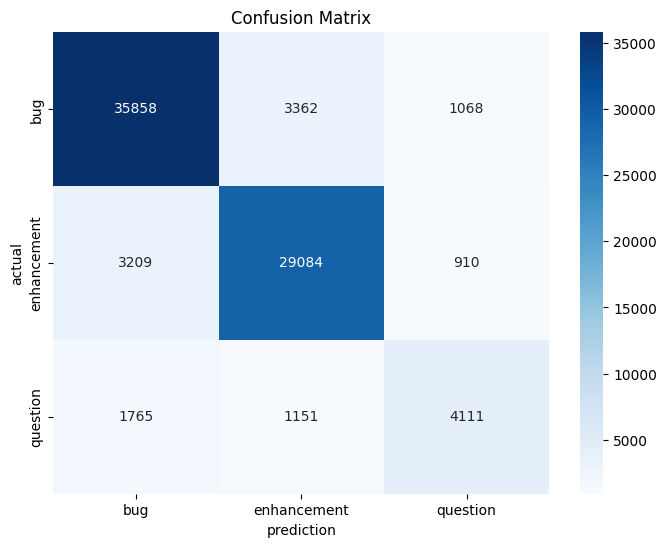

In [49]:
confusion_matrix = confusion_matrix(actual_labels, predicted_labels)
plt.figure(figsize = (8,6))
sns.heatmap(confusion_matrix,
            annot = True,
            fmt = 'd',
            cmap = 'Blues',
            xticklabels = label_names,
            yticklabels = label_names)
plt.xlabel('prediction')
plt.ylabel('actual')
plt.title('Confusion Matrix')
plt.show()

save predictions

In [50]:
predictions = pd.DataFrame(columns = ['text', 'labels', 'actual_labels', 'prediction'])

In [51]:
predictions['text'] = test['text']
predictions['labels'] = test['labels']
predictions['actual_labels'] = model_outputs_df['actual']
predictions['prediction'] = model_outputs_df['prediction']
predictions.head()

,text,labels,actual_labels,prediction
0,time 2020-04-07T09:08:50Z author NONE title er...,1,1,0
1,time 2020-11-27T07:17:21Z author OWNER title a...,1,1,1
2,time 2021-01-02T19:35:34Z author OWNER title a...,1,1,1
3,time 2021-01-02T20:55:34Z author OWNER title p...,0,0,0
4,time 2020-12-29T15:34:35Z author OWNER title c...,0,0,0


In [52]:
predictions.to_csv('/content/drive/My Drive/nlbse22/case3/nlbse22_test_roberta_preds.csv')
predictions.to_pickle('/content/drive/My Drive/nlbse22/case3/nlbse22_test_roberta_preds.pkl')

Performance on training set

In [53]:
hours, remainder = divmod((datetime.datetime.now() - start).total_seconds(), 3600)
minutes, seconds = divmod(remainder, 60)
print('-'*5,  name, ', duration is:', '%dh:%dm:%ds' % (hours, minutes, seconds), '-'*5, '\n\n')
results_train, model_outputs_train, wrong_pred_train = model.eval_model(train, verbose=True, **metrics_recom)
results_train

----- roberta , duration is: 1h:20m:13s ----- 




  0%|          | 0/691253 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/6913 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1506: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


{'mcc': 0.8442464537434616,
 'accuracy': 0.9116618662052823,
 'p_micro': 0.9116618662052823,
 'p_macro': 0.8766440151752297,
 'p_w': 0.9104573863829872,
 'r_micro': 0.9116618662052823,
 'r_macro': 0.8548660668477428,
 'r_w': 0.9116618662052823,
 'f_micro': 0.9116618662052823,
 'f_macro': 0.8649734390992548,
 'f_w': 0.9108448605542966,
 'classificationReport': {'0.0': {'precision': 0.9230145611738317,
   'recall': 0.9339437787323838,
   'f1-score': 0.9284470077354976,
   'support': 344994.0},
  '1.0': {'precision': 0.9205000293039788,
   'recall': 0.9270454663819593,
   'f1-score': 0.9237611533391688,
   'support': 288015.0},
  '2.0': {'precision': 0.7864174550478785,
   'recall': 0.7036089554288854,
   'f1-score': 0.7427121562230982,
   'support': 58244.0},
  'accuracy': 0.9116618662052823,
  'macro avg': {'precision': 0.8766440151752297,
   'recall': 0.8548660668477428,
   'f1-score': 0.8649734390992548,
   'support': 691253.0},
  'weighted avg': {'precision': 0.9104573863829872,
   '

get the confusion matrix for training set

In [54]:
model_outputs_df_train = pd.DataFrame(model_outputs_train, columns = ['bug', 'enhancement', 'question'])
model_outputs_df_train['prediction'] = model_outputs_df_train.apply(get_prediction, axis = 1)
model_outputs_df_train['actual'] = train['labels']
predicted_labels_train = model_outputs_df_train['prediction']
actual_labels_train = model_outputs_df_train['actual']

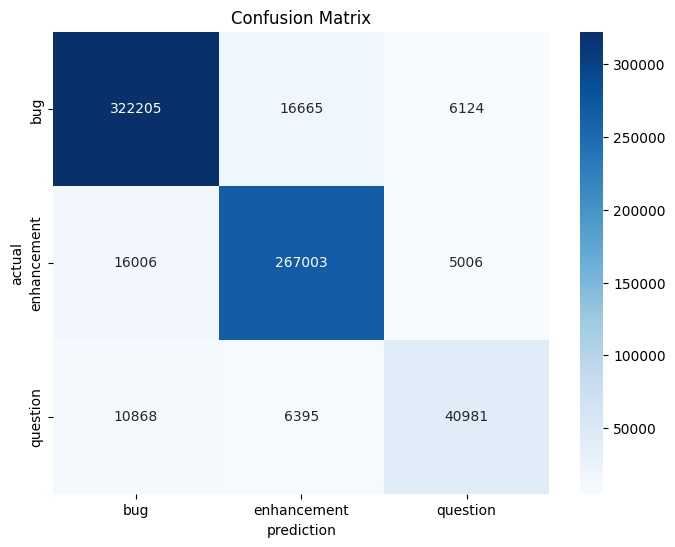

In [55]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(actual_labels_train, predicted_labels_train)
plt.figure(figsize = (8,6))
sns.heatmap(confusion_matrix,
            annot = True,
            fmt = 'd',
            cmap = 'Blues',
            xticklabels = label_names,
            yticklabels = label_names)
plt.xlabel('prediction')
plt.ylabel('actual')
plt.title('Confusion Matrix')
plt.show()

save predictions of training set

In [56]:
predictions_train = pd.DataFrame(columns = ['text', 'labels', 'actual_labels', 'prediction'])
predictions_train['text'] = train['text']
predictions_train['labels'] = train['labels']
predictions_train['actual_labels'] = model_outputs_df_train['actual']
predictions_train['prediction'] = model_outputs_df_train['prediction']
predictions_train.head()

,text,labels,actual_labels,prediction
0,time 2021-05-26T20:57:00Z author OWNER title t...,1,1,1
1,time 2020-07-26T20:14:04Z author OWNER title b...,1,1,1
2,time 2020-12-04T09:33:18Z author NONE title re...,1,1,1
3,time 2020-09-22T01:49:32Z author OWNER title u...,1,1,1
4,time 2020-09-22T01:52:14Z author OWNER title d...,1,1,1


In [57]:
predictions_train.to_csv('/content/drive/My Drive/nlbse22/case3/nlbse22_train_roberta_preds.csv')
predictions_train.to_pickle('/content/drive/My Drive/nlbse22/case3/nlbse22_train_roberta_preds.pkl')